## What is OneContext?

OneContext makes it really easy to compose and deploy custom RAG (Retrieval
Augmented Generation) pipelines. 

RAG makes it possible to augment large
language models with domain-specific knowledge, without the expensive
fine-tuning step.

## How does it work?
OneContext is made up of three key components: knowledge bases, pipelines and
vector indexes.


<div>
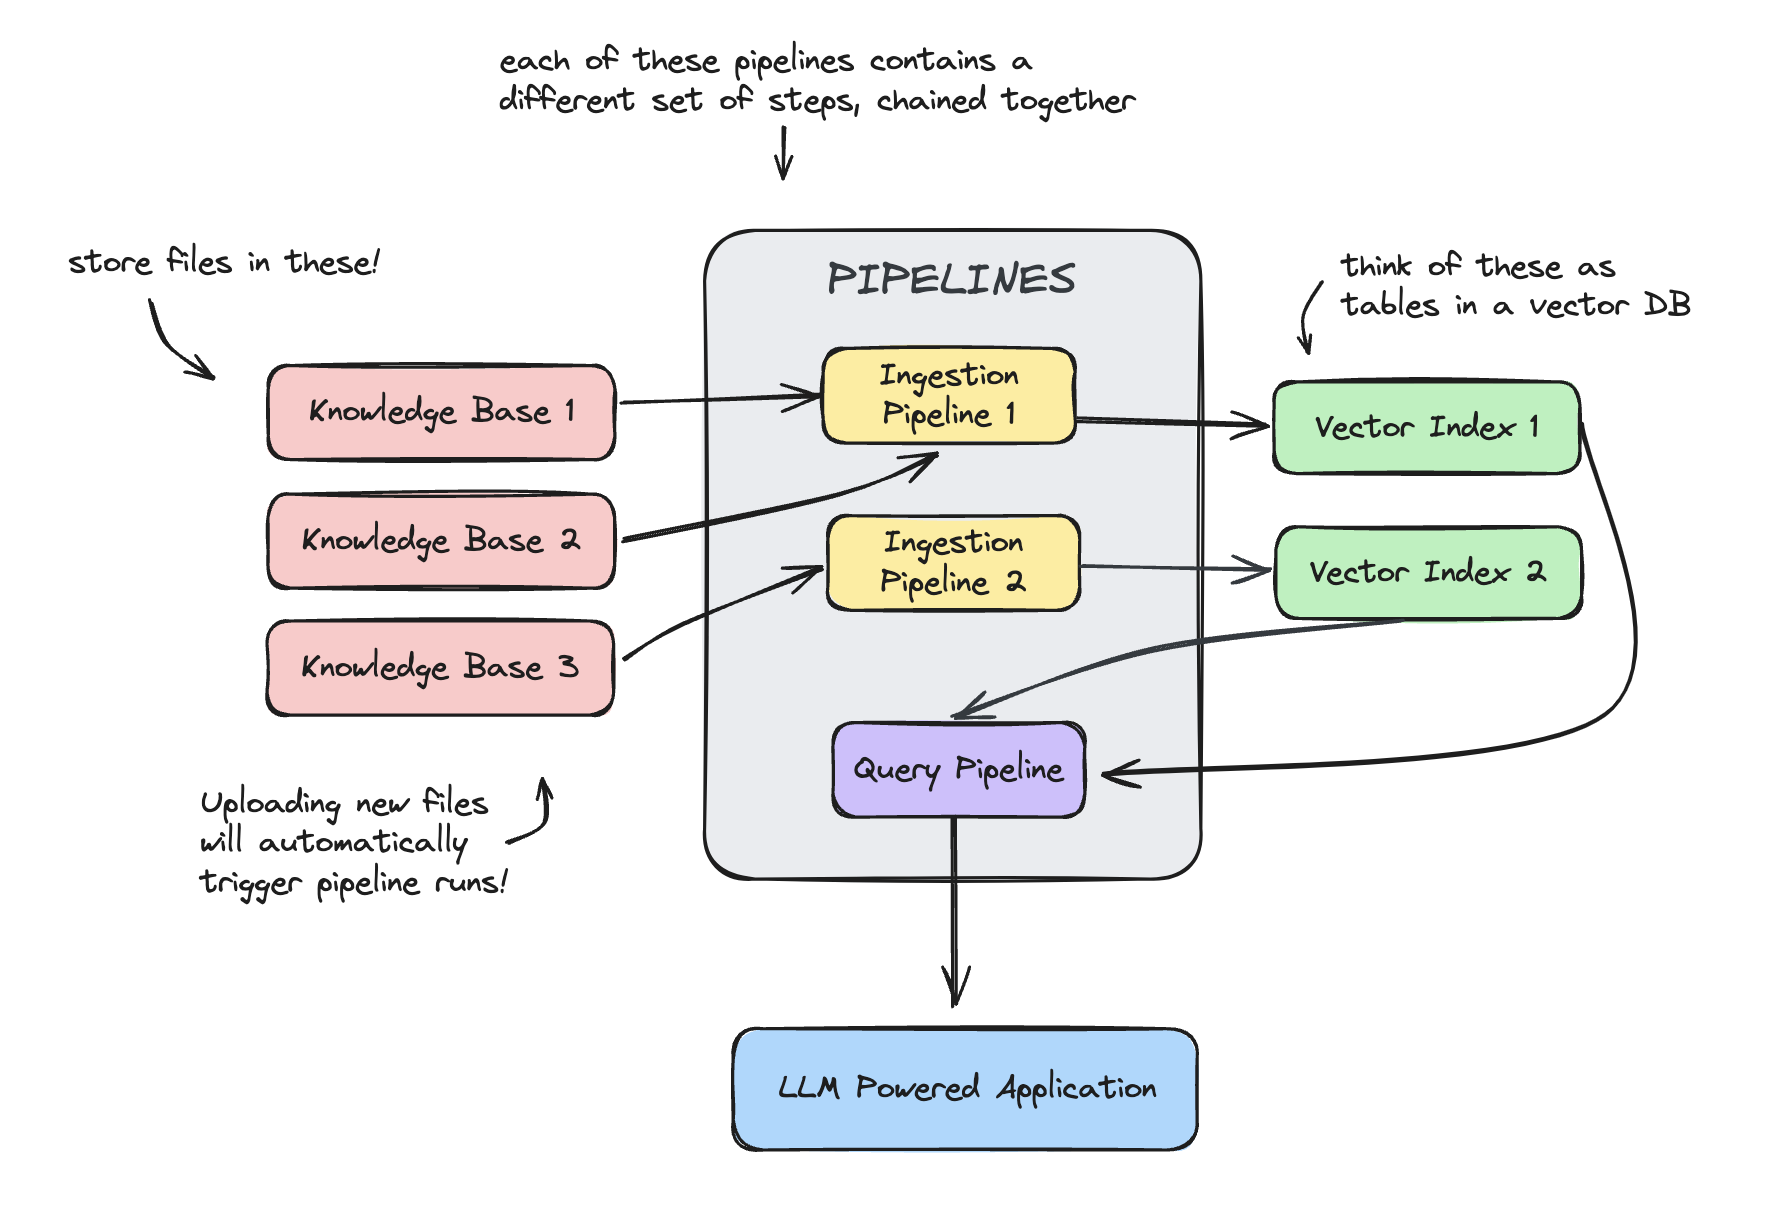
</div>

- [Knowledge Base](./knowledgebase/python_knowledgebase.md) : A knowledge base is where you store
  your files. Think of this as a folder, you can upload and delete files from a
  knowledge base.

- [Vector Index](./vectorindex/python_vectorindex.md) : A vector index is a collection of chunks
  (processed parts of a file) with associated vectors. These indexes allow for
  efficient semantic search based on vector similarity.

- [Pipeline](./pipelines/python_pipelines.md): A pipeline is a collection of `steps`.
You can chop and change between a wide variety of pipelines just by swapping in and out various `steps` in your pipeline. For example, a typical `ingestion` pipeline starts off with a [Preprocessor](./steps/preprocessor.md) step to go from files to text, then through a [Chunker](./steps/chunker.md) step to split the text into chunks, then through a [SentenceTransformerEmbedder](./steps/sentencetransformerembedder.md) step to convert the chunks into embeddings, and finally through a [ChunkWriter](./steps/chunkwriter.md) step to save those embeddings to a Vector Index.
Another example of a pipeline would be a `query` pipeline, which can be used to define custom query logic, again, via composition of `steps`, to let your retrieve and process chunks from a vector index to provide context to your
LLM application at runtime.



In [1]:
from onecontext import OneContext

# ONECONTEXT_API_KEY env variable is used when not provied in arguments
oc = OneContext()


## Create Knowledge Base

In [2]:
# # A knowledge base is a collection of files.
knowledgebase = oc.create_knowledgebase(name="my_kb")

## Create Vector Index

In [3]:
oc.create_index("demo_vector_index", model="BAAI/bge-base-en-v1.5")

VectorIndex(name='demo_vector_index', model_name='BAAI/bge-base-en-v1.5')

## Create Pipeline: Connect Knowledge Base and Vector Index

In [4]:
ingestion_yaml = """

steps:
  - step: KnowledgeBaseFiles
    name: input
    step_args:
      # specify the source knowledgebases to watch
      knowledgebase_names: ["my_kb"]
    inputs: []

  - step: Preprocessor
    name: preprocessor
    step_args: {}
    inputs: [input]

  - step: Chunker
    name: simple_chunker
    step_args:
      chunk_size_words: 200
      chunk_overlap: 30
    inputs: [preprocessor]

  - step: SentenceTransformerEmbedder
    name: sentence-transformers
    step_args:
      model_name: BAAI/bge-base-en-v1.5
    inputs: [ simple_chunker ]

  - step: ChunkWriter
    name: save
    step_args:
      vector_index_name: demo_vector_index
    inputs: [sentence-transformers]
"""

In [5]:
# deploy an ingesiton pipeline that watches the knowledge base we just ceated
oc.deploy_pipeline("my_ingestion_pipeline", pipeline_yaml=ingestion_yaml)

Pipeline(name='my_ingestion_pipeline', id=None, yaml_config='\n\nsteps:\n  - step: KnowledgeBaseFiles\n    name: input\n    step_args:\n      # specify the source knowledgebases to watch\n      knowledgebase_names: ["my_kb"]\n    inputs: []\n\n  - step: Preprocessor\n    name: preprocessor\n    step_args: {}\n    inputs: [input]\n\n  - step: Chunker\n    name: simple_chunker\n    step_args:\n      chunk_size_words: 200\n      chunk_overlap: 30\n    inputs: [preprocessor]\n\n  - step: SentenceTransformerEmbedder\n    name: sentence-transformers\n    step_args:\n      model_name: BAAI/bge-base-en-v1.5\n    inputs: [ simple_chunker ]\n\n  - step: ChunkWriter\n    name: save\n    step_args:\n      vector_index_name: demo_vector_index\n    inputs: [sentence-transformers]\n', run_id=None)

## Upload Files to Knowledge Base

In [6]:
knowledgebase = oc.KnowledgeBase(name="my_kb")
run_id= knowledgebase.upload_file("babbage.pdf")

## Create Query Pipeline

In [7]:
query_yaml = """
steps:
  - step: Retriever
    name: retriever
    step_args:
      query: "placeholder"
      model_name: BAAI/bge-base-en-v1.5
      vector_index_name: demo_vector_index
      top_k: 100
      metadata_filters: { }
    inputs: [ ]


  - step: Reranker
    name: reranker
    step_args:
      query: "placeholder"
      model_name: BAAI/bge-reranker-base
      top_k: 5
      metadata_filters: { }
    inputs: [ retriever ]
"""

In [8]:
# deploy a two-step query  pipeline to query the index
query_pipeline = oc.deploy_pipeline("basic_query", pipeline_yaml=query_yaml)

## List runs

In [9]:
import time
while oc.list_runs(status="RUNNING"):
    time.sleep(1)

## Run the query

In [10]:
query = "Can machines think?"
retriever_top_k = 50
top_k = 5

# overide the step_args for the two steps of the query pipeline by
# passing dict in the form {step_name: step_args_dict}
override_args = {
    "retriever": {
        "top_k": retriever_top_k,
        "query": query,
    },
    "reranker": {"top_k": top_k, "query": query},
}

In [11]:
query_pipeline = oc.Pipeline("basic_query")
chunks = query_pipeline.run(override_args)
print(chunks[0].content)

Those labours which belong to the various branches of the mathematical sciences, although on ﬁrst consideration they seem to be the exclusive province of intellect, may, nevertheless, be divided into two distinct sections; one of which may be called the mechanical, because it is subjected to precise and invariable laws, that are capable of being expressed by means of the operations of matter; while the other, demanding the intervention of reasoning, belongs more specially to the domain of the understanding. This admitted, we may propose to execute, by means of machinery, the mechanical branch of these labours, reserving for pure intellect that which depends on the reasoning faculties. Thus the rigid exactness of those laws which regulate numerical calculations must frequently have suggested the employment of material instruments, either for executing the whole of such calculations or for abridging them; and thence have arisen several inventions having this object in view, but which hav

In [12]:
print("filename", chunks[0].metadata_json["file_name"])
print("page number", chunks[0].metadata_json["page_number"])

filename babbage.pdf
page number 2


In [13]:
print("coordinates", chunks[0].metadata_json["coordinates"])

coordinates [{'points': [[94.507, 164.16626539999993], [94.507, 215.72236539999983], [514.1204289699998, 215.72236539999983], [514.1204289699998, 164.16626539999993]], 'system': 'PixelSpace', 'layout_width': 595.276, 'layout_height': 841.89}, {'points': [[94.507, 220.44726539999988], [94.507, 258.4543653999998], [514.1211678599998, 258.4543653999998], [514.1211678599998, 220.44726539999988]], 'system': 'PixelSpace', 'layout_width': 595.276, 'layout_height': 841.89}]
